## Objective
Use model's templates to find spike times in recording
Steps 5-8 in dl.ipynb from PropSignal:

Run prop algorithm with DL templates

As I mentioned, I still think that the sequences algorithm is helpful for detecting units since in this case the results are averaged over many spikes. However, the sequence during a single spike is too variable to be a good measure for its detection. Instead, we can use the model output directly. We would do this as follows:

Before real time analysis:
1. For the first part of the recording, we use the DL output to detect sequences according to the latest version of the algorithm.
2. For each detected sequence, we take the DL model prediction output per channel and average this over all the spike detections in the first part of the recording that led to the unit detection.
3. From the averaged model prediction output, we take a certain amount of frames before and after the waveform trough of the channel with on average the highest trough amplitude. Let's make the number of frames before and after the trough adjustable parameters that we can tune later. For now, maybe we can use 0.5ms before and after. 
4. We concatenate all the averaged model prediction outputs per channel into a long array. This gives us a long array for each detected unit in 1.

During real time analysis:
5. Every 0.5ms (or more if we can do so computationally), we take the model output from all channels and concatenate them into a long array, similar to what we did in step 4.
6. We multiply this array with each of the arrays in step 4 (element wise multiplication) and sum the results. This gives us a single value for each unit.
7. If the results for one or multiple arrays from 4 pass a threshold, we choose the array from 4 that leads to the highest score and assign a spike to this unit. Let's explore what a good threshold value would be and tune this later.
8. The spike time is the time of the trough in the channel with the highest amplitude identified in step 3.

## General setup

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch

from tqdm import tqdm

from meta import SI_MOUSE

In [3]:
RECORDING = np.load(SI_MOUSE[2] / "traces.npy", mmap_mode="r")
SAMP_FREQ = 30

MODEL_ROOT = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120")
MODEL_OUTPUTS = np.load(MODEL_ROOT / "outputs.npy", mmap_mode="r")

PROP_ROOT = MODEL_ROOT / "prop_signal"
# UNIT_TEMPLATES = np.load(PROP_ROOT / "unit_templates.npy", mmap_mode="r")
UNIT_TEMPLATES = np.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120/230713/60_sec/unit_templates.npy", mmap_mode="r")

In [4]:
num_chans, num_output_frames = MODEL_OUTPUTS.shape

num_window_frames = UNIT_TEMPLATES.shape[-1]
unit_templates = torch.tensor(UNIT_TEMPLATES.reshape((UNIT_TEMPLATES.shape[0], -1)), device="cuda")

In [6]:
FIRST_SECONDS = 60
num_output_frames = int(FIRST_SECONDS * 1000 * 30 - 80) # 80 = 2 * FRONT_BUFFER

## Extract spike times

### Extract spike scores

In [7]:
STRIDE = 1

BATCH_SIZE = 2000  #  Each sample refers to sample of (recording_num_chans, window_size)
NUM_WORKERS = 8

In [10]:
SPIKE_SCORES_PATH = "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120/230713/60_sec/spike_scores.npy"

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class OutputDataset(Dataset):
    """Class to get output windows from MODEL_OUTPUTS to extract spike times"""
    def __init__(self):
        super().__init__()
        
        self.start_frames_all = np.arange(0, num_output_frames-num_window_frames+1, STRIDE)

    def __len__(self):
        return len(self.start_frames_all)
    
    def __getitem__(self, idx):
        start_frame = self.start_frames_all[idx]
        return MODEL_OUTPUTS[:, start_frame:start_frame+num_window_frames].flatten() # , start_frame
    
output_dataset = OutputDataset()

print("Allocating memory for spike scores ...")
spike_scores_all = np.zeros((len(unit_templates), len(output_dataset)), dtype="float16")
np.save(SPIKE_SCORES_PATH, spike_scores_all)
spike_scores_all = np.load(SPIKE_SCORES_PATH, mmap_mode="r+")

print("Extracting spike scores ...")
output_dataloader = DataLoader(output_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
for i, windows in tqdm(enumerate(output_dataloader), total=len(output_dataloader)):
    windows = torch.sigmoid(windows.to(device="cuda"))
    windows = F.cosine_similarity(windows.unsqueeze(1), unit_templates, dim=-1).cpu()
    i *= BATCH_SIZE
    spike_scores_all[:, i:i+BATCH_SIZE] = windows.T

Allocating memory for spike scores ...
Extracting spike scores ...


100%|██████████| 900/900 [01:51<00:00,  8.05it/s]


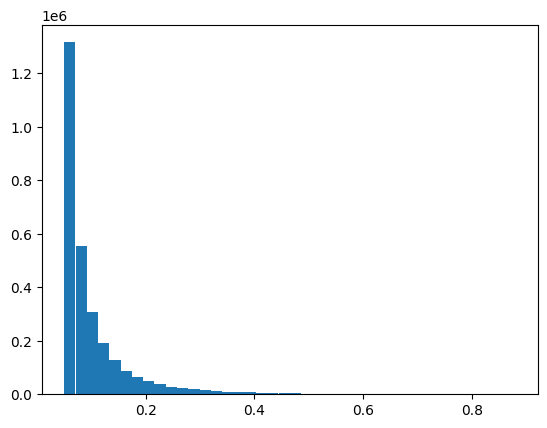

In [12]:
spike_scores_all = np.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120/230713/spike_scores.npy", mmap_mode="r")

# spike_scores = spike_scores_all[17]#[spike_scores_all > 0]
# spike_scores = spike_scores[spike_scores>0.05]
scores = spike_scores_all[spike_scores_all > 0.05].flatten()
plt.hist(scores, bins=40)
plt.show()

In [57]:
FRONT_BUFFER = 40  # Model's front sample buffer

def score_frame_to_time(frame):
    # Convert frame in spike_scores_all to ms from beginning of recording
    return ((frame + num_window_frames//2) + FRONT_BUFFER) / SAMP_FREQ

### Plot some spikes

In [53]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

In [67]:
propagations = np.load(PROP_ROOT / "propagations.npy", allow_pickle=True)

In [105]:
# Pick unit and high spike score
UNIT_IDX = 40
prop = propagations[UNIT_IDX]
chans = prop.ID.values
sorted_ind = np.argsort(spike_scores_all[UNIT_IDX])
sorted_spikes = spike_scores_all[UNIT_IDX, sorted_ind]

In [144]:
FRAME = sorted_ind[35910000]
spike_scores_all[UNIT_IDX, FRAME]

0.1583

In [158]:
FRAME = sorted_ind[np.searchsorted(sorted_spikes, 0.1)+10]
spike_scores_all[UNIT_IDX, FRAME]

0.10004

In [160]:
spike_scores_all[UNIT_IDX, FRAME-10:FRAME+10]

memmap([0.01787, 0.0195 , 0.02167, 0.02405, 0.03036, 0.0676 , 0.1089 ,
        0.1614 , 0.3164 , 0.1742 , 0.10004, 0.05234, 0.02577, 0.01817,
        0.01613, 0.01411, 0.01228, 0.01133, 0.01083, 0.01034],
       dtype=float16)

20915834


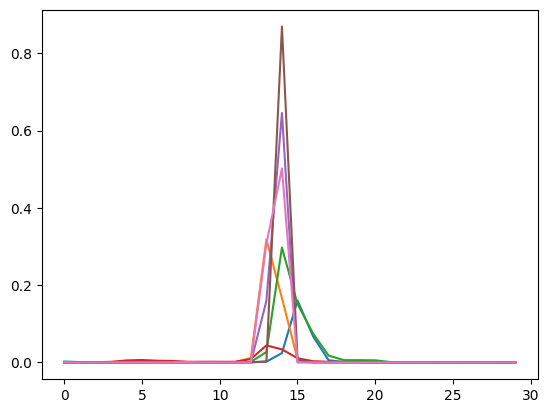

In [159]:
outputs = MODEL_OUTPUTS[:, FRAME:FRAME+num_window_frames]    
print(FRAME)
plt.plot(sigmoid(outputs[chans].T))
plt.show()

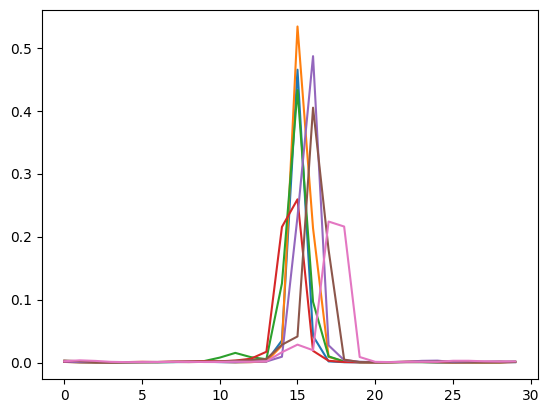

In [108]:
temp = unit_templates[UNIT_IDX].reshape(num_chans, num_window_frames)
plt.plot(temp[chans].cpu().T)
plt.show()

In [95]:
outputs_torch = torch.tensor(outputs, device="cuda").flatten()
F.cosine_similarity(torch.sigmoid(outputs_torch), temp.flatten(), dim=0)

### Find peaks in spike scores to get spike times

In [192]:
from scipy.signal import find_peaks

MIN_SCORE = 0.575 # Minimum score needed for a frame to have a spike

# propagations = np.load(PROP_ROOT / "propagations.npy", allow_pickle=True)

In [193]:
from scipy.signal import find_peaks

MIN_SCORE = 0.575 # Minimum score needed for a frame to have a spike

spike_times = []

for idx in tqdm(range(len(unit_templates))):
    scores = np.concatenate([[-np.inf], spike_scores_all[idx, :], [-np.inf]]) # pad front and end in case peak occurs in beginning
    peaks = find_peaks(scores, height=MIN_SCORE)[0] - 1  # -1 to account for padding
    times = score_frame_to_time(peaks)
    spike_times.append(np.sort(times))
    
    # prop_amps = []
    # rec_frames = peaks + num_window_frames//2 + FRONT_BUFFER
    # for chan in propagations[idx].ID:
    #     amps = RECORDING[chan, rec_frames]
    #     prop_amps.append(np.mean(amps))
    
# np.save(PROP_ROOT / f"propagating_times_{MIN_SCORE}.npy", np.array(spike_times, dtype=object))
# np.save(PROP_ROOT / "propagating_amps.npy", np.array(spike_times, dtype=object))

100%|██████████| 124/124 [00:32<00:00,  3.80it/s]


(array([1, 4]), {'peak_heights': array([5., 4.])})